In [115]:
# Load libraries
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import string
import pickle

from keras.layers import Dense, Embedding, Dropout, LSTM, SpatialDropout1D, MaxPooling1D, GlobalMaxPool1D, GlobalMaxPooling1D, Bidirectional, Conv1D
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.initializers import glorot_uniform
from keras.models import Sequential, Model
from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras import regularizers


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.externals import joblib
from sklearn.metrics import f1_score
from sklearn import preprocessing


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
nltk.download('punkt')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxkulagin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maxkulagin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [91]:
def process_text(text):
    # Function processing text for Word2Vec
    tokens = word_tokenize(text.lower())
    # delete punctuation
    table = str.maketrans('', '', string.punctuation)
    words_without_punct = [w.translate(table) for w in tokens]
    # delete all except text
    words = [word for word in words_without_punct if word.isalpha()]
    # delete stopwords
    stop_words = set(stopwords.words('russian'))
    words_without_stop_words = [w for w in words if not w in stop_words]
    return ' '.join(words_without_stop_words)


def create_datasets(data):
    list_train = []
    for i in range(data.shape[0]):
        text = data.iloc[i, 0]
        result = text.split('Описание обращения:')
        result_text = result[0].split('Дополнительные параметры:')[0]
        if len(result) == 2:
            result_text = result[1].split('Дополнительные параметры:')[0]
        preproc_text = process_text(result_text)
        list_train.append(preproc_text)
    return list_train

In [5]:
data = pd.read_excel('./new_data/Анализ запросов 2018 полный.xlsx')
data = data[['ПОДРОБНОЕ_ОПИСАНИЕ', 'код ']]
data.columns = ['requests', 'label']
data.label = data.label.astype(str)

In [248]:
data.shape

(18460, 3)

In [15]:
data1 = pd.read_excel('./new_data/Часть 2.xlsx')
data1.columns = ['№', 'Подробное описание', 'Самостоятельность', 'I уровень класс',
       'I уровень вероятность', 'I уровень корректность', 'II уровень класс',
       'II уровень вероятность', 'II уровень корректность',
       'III уровень класс',
       'III уровень вероятность', 'III уровень корректность', 'IV уровень класс',
       'IV уровень вероятность', 'IV уровень корректность', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23']
data1 = data1.iloc[1:, :-9]

In [247]:
data1.shape

(9340, 15)

In [75]:
level_1 = data1[['Подробное описание', 'I уровень класс', 'I уровень корректность']].dropna()
level_2 = data1[['Подробное описание', 'II уровень класс', 'II уровень корректность']].dropna()
level_1['I уровень корректность'] = level_1['I уровень корректность'].apply(lambda x: str(x).strip())
level_1 = level_1[level_1['I уровень корректность'] == '+'].iloc[:, :2]
level_1['Подробное описание'] = level_1['Подробное описание'].apply(process_text)

In [146]:
level_2['II уровень корректность'] = level_2['II уровень корректность'].apply(lambda x: str(x).strip())
level_2 = level_2[level_2['II уровень корректность'] == '+'].iloc[:, :2]
level_2['Подробное описание'] = level_2['Подробное описание'].apply(process_text)

In [231]:
level_2.iloc[0][0]

'могу завести контр лист ст кедроваясибирская'

In [ ]:
level_2

In [327]:
requests = create_datasets(data)
data['requests'] = requests

In [328]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    for i in range(len(texts)):
        string = texts[i].split()
        for j in range(len(string)):
            if (string[j] in word2idx) and (j < max_text_len):
                data[i,j] = word2idx[string[j]]
    return data

def get_train_test_data(data, num_class, max_features=1000, max_len=64):
    le = preprocessing.LabelEncoder()
    new_terget = le.fit_transform(data.target)
    categorical_target = to_categorical(new_terget, num_classes = num_class)
    countUnique = np.unique(categorical_target.argmax(axis=1), return_counts=True)[1]
    classWeights = 1 - (countUnique / sum(countUnique))
    classWeights = dict(zip(range(len(classWeights)), classWeights))
    X_train, X_test, y_train, y_test = train_test_split(data.text, categorical_target, test_size=0.3)
    # Tokenization and encoding text corpus
    tk = Tokenizer(num_words=max_features)
    tk.fit_on_texts(X_train)
    # dictionaries
    word2index = tk.word_index
    X_train_convert = convert(X_train.values, word2index, max_len)
    X_test_convert = convert(X_test.values, word2index, max_len)
    return X_train_convert, X_test_convert, y_train, y_test, word2index, le, classWeights

In [329]:
def get_data(data, max_features=1000, max_len=64):
    # Tokenization and encoding text corpus
    tk = Tokenizer(num_words=max_features)
    tk.fit_on_texts(data)
    # dictionaries
    word2index = tk.word_index
    result = convert(data.values, word2index, max_len)
    return result

In [334]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.tight_layout()
    
def result_metrics_nn(predict_cls_transform, y_test_ot_fact, name=None, savefile=False):
    f1_each_class = dict(zip(['Класс_'+str(i) for i in np.unique(y_test_ot_fact)], 
                          f1_score(y_test_ot_fact, predict_cls_transform, average=None)))
    for key, val in f1_each_class.items():
        print(key + ' F1', '=', f1_each_class[key])
    print('Средняя F1 для каждого класса =', np.mean(list(f1_each_class.values())))
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test_ot_fact, predict_cls_transform)
    # np.set_printoptions(precision=2)
    class_names = np.unique(y_test_ot_fact)
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='')
    if savefile:
        plt.savefig(name.split('.png')[0] + '_1.png', dpi=300)

    # Plot normalized confusion matrix
    plt.figure(figsize=(10,10))
    mat = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='')
    if savefile:
        plt.savefig(name.split('.png')[0] + '_2.png', dpi=300)
    plt.show()
    return cnf_matrix

def model_rnn(input_shape, word2index, output_dim=128, num_classes=10):
    model = Sequential()
    model.add(Embedding(input_dim=len(word2index) + 1, output_dim=output_dim, input_shape=(input_shape,)))
    model.add(LSTM(64, return_sequences = True))
    model.add(GlobalMaxPool1D())
    model.add(Dense(20, activation="relu"))
    model.add(Dropout(0.05))
    model.add(Dense(num_classes, activation="softmax"))
    return model

def model_cnn(input_shape, word2index, output_dim=128, num_classes=10):
    model = Sequential()
    model.add(Embedding(input_dim=len(word2index) + 1, output_dim=output_dim, input_shape=(input_shape,)))
    model.add(Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu', strides=2))
    model.add(GlobalMaxPooling1D())
#     model.add(Dropout(rate=0.1))
    model.add(Dense(20, activation="relu"))
#     model.add(Dropout(rate=0.8))
#     model.add(Dense(50, activation="relu"))
#     model.add(Dropout(rate=0.8))
#     model.add(Dense(40, activation="relu", kernel_regularizer=regularizers.l2(0.1)))
#     model.add(Dropout(rate=0.5))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))
    return model

def trainmodel(data_train, batch_size=128, epochs=10, resize=False, threshold=0.95, save_file=False, name_file=None):
    # Process data
    labels = [v[0].split('.') for v in data_train.label.str.split(',')]
    arrLabel = []
    for v in labels:
        if len(v) > 2:
            arrLabel.append(v[2])
        else:
            arrLabel.append('ERR')  
    data_train['label_second_1'] = pd.Series(arrLabel)
    data_train = data_train[(data_train['label_second_1'] != 'ERR') & (data_train['label_second_1'] != '')]
    dataTrain = data_train[['requests', 'label_second_1']]
    dataTrain.columns = ['text', 'target']
    if resize:
        validTarget = (dataTrain.target.value_counts() > np.quantile(dataTrain.target.value_counts(), threshold))
        validTarget = list(validTarget[validTarget==True].index)
        dataTrain = dataTrain[dataTrain.target.isin(validTarget)]
    dataTrain = dataTrain.dropna()
    dataTrain['target'] = dataTrain.target.astype(int)
    numClass = len(dataTrain['target'].unique())
    print(dataTrain['target'].value_counts())
    X_train, X_test, y_train, y_test, word2index, le, class_weights = get_train_test_data(dataTrain, numClass)
    # Train model
    model = model_cnn(X_train.shape[1], word2index, output_dim=128, num_classes=numClass)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    model.fit(X_train,y_train, batch_size=128, epochs=epochs, validation_data=(X_test, y_test), 
              class_weight=class_weights)
    # Predict
    predict_cls = model.predict_classes(X_test)
    predict_cls_transform = le.inverse_transform(predict_cls)
    y_test_fact = le.inverse_transform(np.argmax(y_test, axis=1))
    result_metrics_nn(predict_cls_transform, y_test_fact, name=name_file, savefile=save_file)
    return model, word2index, le, class_weights

### Обучение первого уровня

In [335]:
labels = data.label.str.split('.').dropna()
firstLayerLabel = []
for label, idx in zip(labels, labels.index):
    first = label[0]
    if (first == '015') or (first == '15, 15') or (first == '51') or (first == '115') or (first == '156'):
        first = '15'
    firstLayerLabel.append(first)
data['label_first'] = firstLayerLabel
data['label_first'].value_counts()

15     16212
0       2234
1          7
           2
26         1
3          1
5          1
nan        1
16         1
Name: label_first, dtype: int64

In [336]:
dataForFirstModel = data[(data['label_first'] == '15') | (data['label_first'] == '0')]
dataForFirstModel = dataForFirstModel[['requests', 'label_first']]
dataForFirstModel.columns = ['text', 'target']
level_1.columns = ['text', 'target']
dataForFirstModel = pd.concat([dataForFirstModel, level_1])
dataForFirstModel.index = range(dataForFirstModel.shape[0])
dataForFirstModel['target'] = dataForFirstModel.target.astype(int)

In [337]:
X_train_convert, X_test_convert, y_train, y_test, word2index, le, class_weights = get_train_test_data(dataForFirstModel,
                                                                                                      2)

In [345]:
X_train, X_test, y_train, y_test =  train_test_split(dataForFirstModel.text, dataForFirstModel.target)

In [346]:
from keras_bert import extract_embeddings

model_path = 'rubert_cased_L-12_H-768_A-12_v2'
embeddings = extract_embeddings(model_path, X_train)

KeyboardInterrupt: 

In [348]:
8192/64

128.0

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [217]:
class_weights[0] += 1

In [341]:
model1 = model_cnn(X_train_convert.shape[1], word2index, output_dim=256, num_classes=2)
model1.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 64, 256)           4212992   
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 30, 128)           163968    
_________________________________________________________________
global_max_pooling1d_40 (Glo (None, 128)               0         
_________________________________________________________________
dense_139 (Dense)            (None, 20)                2580      
_________________________________________________________________
dense_140 (Dense)            (None, 10)                210       
_________________________________________________________________
dense_141 (Dense)            (None, 2)                 22        
Total params: 4,379,772
Trainable params: 4,379,772
Non-trainable params: 0
___________________________________________

In [342]:
model1.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model1.fit(X_train_convert,y_train, batch_size=256, epochs=10,
           validation_data=(X_test_convert, y_test), class_weight=class_weights)

Train on 18510 samples, validate on 7933 samples
Epoch 1/10
18510/18510 [==============================] - 21s 1ms/step - loss: 0.1013 - accuracy: 0.7939 - val_loss: 0.4047 - val_accuracy: 0.8671
Epoch 2/10
18510/18510 [==============================] - 20s 1ms/step - loss: 0.0648 - accuracy: 0.9025 - val_loss: 0.2800 - val_accuracy: 0.9014
Epoch 3/10
18510/18510 [==============================] - 22s 1ms/step - loss: 0.0439 - accuracy: 0.9335 - val_loss: 0.4176 - val_accuracy: 0.8520
Epoch 4/10
18510/18510 [==============================] - 22s 1ms/step - loss: 0.0296 - accuracy: 0.9507 - val_loss: 0.3935 - val_accuracy: 0.8661
Epoch 5/10
18510/18510 [==============================] - 23s 1ms/step - loss: 0.0204 - accuracy: 0.9663 - val_loss: 0.4083 - val_accuracy: 0.8596
Epoch 6/10
18510/18510 [==============================] - 19s 1ms/step - loss: 0.0159 - accuracy: 0.9728 - val_loss: 0.3568 - val_accuracy: 0.8906
Epoch 7/10
18510/18510 [==============================] - 22s 1ms/ste

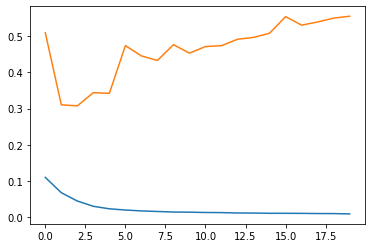

In [340]:
plt.plot(range(len(history.history["loss"])), history.history["loss"])
plt.plot(range(len(history.history["val_loss"])), history.history["val_loss"])
plt.show()

Класс_0 F1 = 0.5019646365422397
Класс_15 F1 = 0.9266811279826463
Средняя F1 для каждого класса = 0.714322882262443
Confusion matrix, without normalization
Normalized confusion matrix


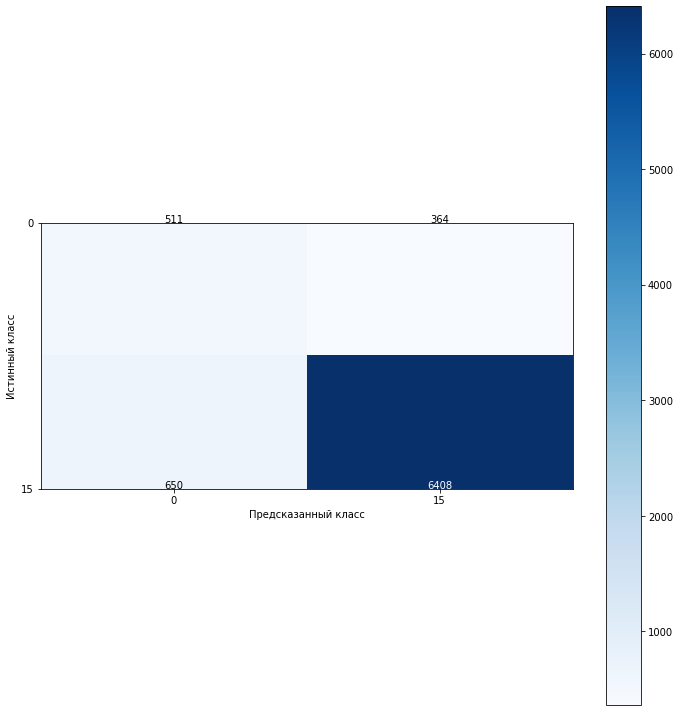

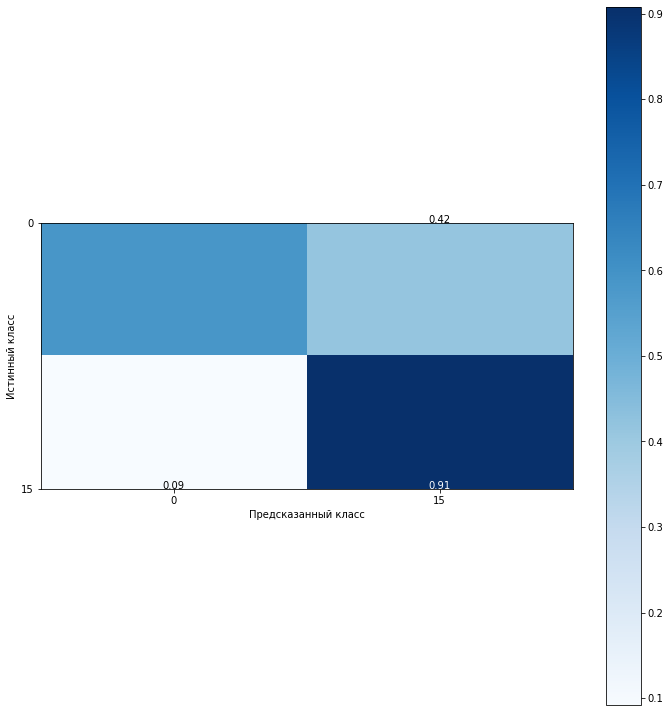

array([[ 511,  364],
       [ 650, 6408]])

In [251]:
predict_cls = model1.predict_classes(X_test_convert)
predict_cls_transform = le.inverse_transform(predict_cls)
y_test_ot_fact = le.inverse_transform(np.argmax(y_test, axis=1))
result_metrics_nn(predict_cls_transform, y_test_ot_fact, './newModels/charts/level_1.png', savefile=False)

In [221]:
model1.save("./models/level_1/model.h5")
with open('./models/level_1/word2index.pickle', 'wb') as f:
    pickle.dump(word2index, f, pickle.HIGHEST_PROTOCOL)
np.save('./models/level_1/classes.npy', le.classes_)

### Обучение второго уровня

In [258]:
dataSecond = data[(data['label_first'] == '15') & (data['label'] != '15')]
labelsSecond = dataSecond.label.str.split('.').dropna()
secondLayerLabel = []
for label, idx in zip(labelsSecond, labelsSecond.index):
    if len(label) > 1:
        if (label[1] == '1, 15') or (label[1] == '2, 15') or (label[1] == '6,15') or (label[1] == '3, 15'):
            secondLayerLabel.append(label[1].split(',')[0])
        elif (len(label[1]) == 2):
            secondLayerLabel.append(label[1][0])
        else:
            secondLayerLabel.append(label[1])
    else:
        print(label)
        secondLayerLabel.append('ERR')
dataSecond['label_second'] = secondLayerLabel
dataSecond = dataSecond[dataSecond['label_second'] != '']

In [259]:
dataForSecondModel = dataSecond[(dataSecond['label_second'] != '5') & (dataSecond['label_second'] != '4')]
dataForSecondModel = dataForSecondModel[['requests', 'label_second']]
dataForSecondModel.columns = ['text', 'target']

In [260]:
level_2.columns = ['text', 'target']

In [261]:
dataForSecondModel = pd.concat([dataForSecondModel, level_2])

In [262]:
dataForSecondModel.shape

(15808, 2)

In [263]:
def changeMetka(x):
    if '.' not in x:
        return "15." + str(x)
    return x
dataForSecondModel['target'] = dataForSecondModel.target.apply(changeMetka)

In [264]:
dataForSecondModel['target'].value_counts()

15.6    10635
15.3     2194
15.1     2151
15.2      828
Name: target, dtype: int64

In [316]:
X_train_convert2, X_test_convert2, y_train2, y_test2, word2index2, le2, class_weight = get_train_test_data(dataForSecondModel, 4)



In [317]:
class_weight[0] += 1
class_weight[1] += 1
class_weight[2] += 1

In [318]:
class_weight

{0: 1.8639296558704452,
 1: 1.9476214574898787,
 2: 1.8612095141700404,
 3: 0.32723937246963564}

In [321]:
model2 = model_cnn(X_train_convert2.shape[1], word2index2, output_dim=256, num_classes=4)
model2.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, 64, 256)           3123968   
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 30, 128)           163968    
_________________________________________________________________
global_max_pooling1d_38 (Glo (None, 128)               0         
_________________________________________________________________
dropout_85 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_131 (Dense)            (None, 100)               12900     
_________________________________________________________________
dropout_86 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_132 (Dense)            (None, 50)              

In [325]:
model2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model2.fit(X_train_convert2,y_train2, batch_size=256, epochs=10, 
           validation_data=(X_test_convert2, y_test2), class_weight=class_weight)

Train on 11065 samples, validate on 4743 samples
Epoch 1/10
11065/11065 [==============================] - 11s 983us/step - loss: 0.3516 - accuracy: 0.9338 - val_loss: 1.1035 - val_accuracy: 0.8691
Epoch 2/10
11065/11065 [==============================] - 8s 762us/step - loss: 0.3205 - accuracy: 0.9394 - val_loss: 1.1689 - val_accuracy: 0.8716
Epoch 3/10
11065/11065 [==============================] - 9s 777us/step - loss: 0.3028 - accuracy: 0.9431 - val_loss: 1.0955 - val_accuracy: 0.8710
Epoch 4/10
11065/11065 [==============================] - 8s 764us/step - loss: 0.2911 - accuracy: 0.9470 - val_loss: 1.2896 - val_accuracy: 0.8680
Epoch 5/10
11065/11065 [==============================] - 9s 769us/step - loss: 0.2963 - accuracy: 0.9456 - val_loss: 1.2863 - val_accuracy: 0.8705
Epoch 6/10
11065/11065 [==============================] - 8s 762us/step - loss: 0.2965 - accuracy: 0.9426 - val_loss: 1.1896 - val_accuracy: 0.8695
Epoch 7/10
11065/11065 [==============================] - 9s 7

Класс_15.1 F1 = 0.7705977382875606
Класс_15.2 F1 = 0.37500000000000006
Класс_15.3 F1 = 0.7724945135332846
Класс_15.6 F1 = 0.9543948240492346
Средняя F1 для каждого класса = 0.7181217689675199
Confusion matrix, without normalization
Normalized confusion matrix


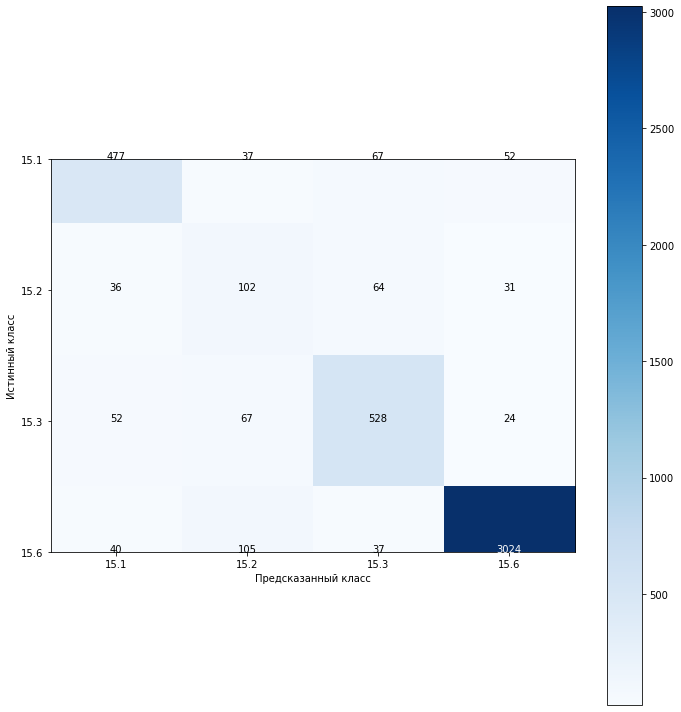

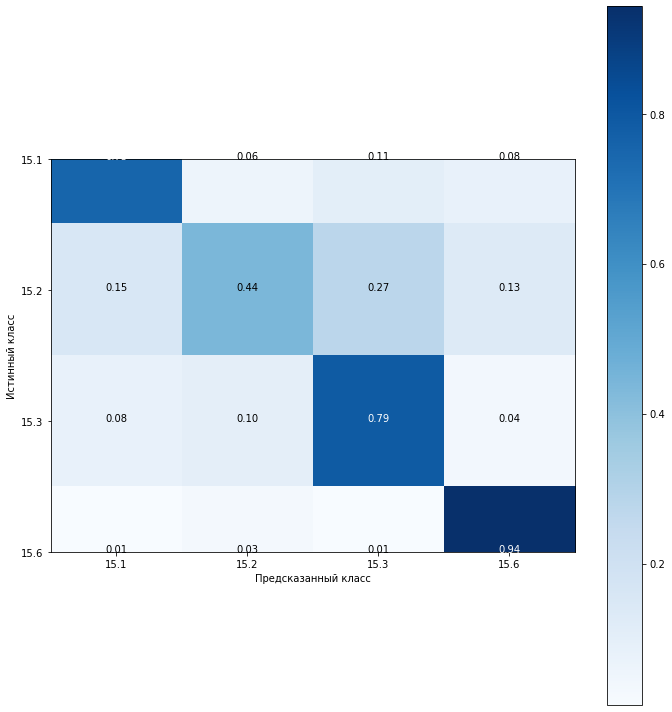

array([[ 477,   37,   67,   52],
       [  36,  102,   64,   31],
       [  52,   67,  528,   24],
       [  40,  105,   37, 3024]])

In [326]:
predict_cls = model2.predict_classes(X_test_convert2)
predict_cls_transform = le2.inverse_transform(predict_cls)
y_test_ot_fact = le2.inverse_transform(np.argmax(y_test2, axis=1))
result_metrics_nn(predict_cls_transform, y_test_ot_fact, './newModels/charts/level_2.png', savefile=False)

In [228]:
model2.save("./models/level_2/model.h5")
with open('./models/level_2/word2index.pickle', 'wb') as f:
    pickle.dump(word2index2, f, pickle.HIGHEST_PROTOCOL)
np.save('./models/level_2/classes.npy', le2.classes_)

### Прочее обучение

In [351]:
from keras.models import load_model

model1 = load_model("../restAPI/models/level_1/model.h5")
model2 = load_model("../restAPI/models/level_2/model.h5")

In [365]:
with open("../restAPI/models/level_1/word2index.pickle", 'rb') as handle:
    word2index1 = pickle.load(handle)
with open("../restAPI/models/level_2/word2index.pickle", 'rb') as handle:
    word2index2 = pickle.load(handle)

In [352]:
from keras.layers import Concatenate, Average, Input
from sklearn.neighbors import NearestNeighbors

In [353]:
dataSecond_1 = dataSecond[(dataSecond['label_second'] == '1') & (dataSecond['label_first'] == '15')]
dataSecond_2 = dataSecond[(dataSecond['label_second'] == '2') & (dataSecond['label_first'] == '15')]
dataSecond_3 = dataSecond[(dataSecond['label_second'] == '3') & (dataSecond['label_first'] == '15')]
dataSecond_6 = dataSecond[(dataSecond['label_second'] == '6') & (dataSecond['label_first'] == '15')]

In [354]:
dataSecond_3.requests.values[22]

'ек асутр ксотп помощь вводе мероприятий устранению замечаний контрольного листа'

In [358]:
newDict = {'5': '0.8', '5.1': '0.78', '.5': '0.78', '1.2': '0.78'}

In [359]:
dictLevel_3 = dict()
dictLevel_4 = dict()
for k, item in newDict.items():
    currListKey = k.split(".")
    currItem = item
    if len(currListKey[0]) == 0:
        continue
    if (len(currListKey) >= 1):
        if (currListKey[0] in dictLevel_3.keys()) and (dictLevel_3[currListKey[0]] > item):
             currItem = dictLevel_3[currListKey[0]]
        dictLevel_3[currListKey[0]] = currItem
    if (len(currListKey) > 1) and (len(currListKey[-1]) != 0):
        if (currListKey[-1] in dictLevel_4.keys()) and (dictLevel_4[currListKey[-1]] > item):
            item = dictLevel_4[currListKey[-1]]
        dictLevel_4[currListKey[-1]] = item


In [360]:
dictLevel_3, dictLevel_4

({}, {})

In [361]:
dictDataSet = {
    "dataSecond_1": dataSecond_1,
    "dataSecond_2": dataSecond_2,
    "dataSecond_3": dataSecond_3,
    "dataSecond_6": dataSecond_6
}

In [648]:
# model, word2index, le, class_weights = trainmodel(dataSecond_1)

In [362]:
model_curr_1 = Input(shape=(64,))
x1 = model1.layers[0](model_curr_1)
model_curr_2 = Input(shape=(64,))
x2 = model2.layers[0](model_curr_2)
average = Average()([x1, x2])
model_output = Model(inputs=[model_curr_1, model_curr_2], outputs=average)

In [366]:
def getCurrData(data, word2index1, word2index2):
    data['OTHER_CLASS'] = data.label.apply(lambda x: 'ERR' if len(x.split('.')) <= 2 else x)
    dataForNeigh = data[data['OTHER_CLASS'] != 'ERR'].dropna()
    dataForNeigh['OTHER_CLASS'] = dataForNeigh['OTHER_CLASS'].apply(lambda x: x if len(x.split(',')) < 2 else 'ERR')
    dataForNeigh = dataForNeigh[dataForNeigh['OTHER_CLASS'] != 'ERR']
    data_new_1 = convert(dataForNeigh.requests.values, word2index1, 64)
    data_new_2 = convert(dataForNeigh.requests.values, word2index2, 64)
    dictValue = dict(zip(range(dataForNeigh['label'].shape[0]), dataForNeigh['label']))
    return [data_new_1, data_new_2], dictValue

In [367]:
convert(["ТЕСТОВЫЙ"], word2index1, 64)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [368]:
def getNeight(data, model_aver):
    predDataSet = model_aver.predict(data)
    predDataSet = predDataSet.reshape(predDataSet.shape[0],  -1) 
    neigh = NearestNeighbors(10, 0.5, metric='cosine')
    neigh.fit(predDataSet)
    return neigh

In [369]:
def trainMultiplyDataSet(dictDataSet, word2index1, word2index2, model_aver):
    newDict = dict()
    for k, item in dictDataSet.items():
        data, dictValue = getCurrData(item, word2index1, word2index2)
        neigh = getNeight(data, model_aver)
        newDict[k] = {"dictValue": dictValue, "cls": neigh}          
    return newDict

In [370]:
resultDict = trainMultiplyDataSet(dictDataSet, word2index1, word2index2, model_output)

In [374]:
for k, item in resultDict.items():
    number_path = k.split('_')[1]
    name_cls = "neigh_cls"
    name_dict = "dict_val"
    filename_cls = '../restAPI/models/neighs_cls/cls_%s/%s.joblib.pkl'%(number_path, name_cls)
    filename_dict = '../restAPI/models/neighs_cls/cls_%s/%s.pickle'%(number_path, name_dict)
    _ = joblib.dump(item['cls'], filename_cls, compress=9)
    with open(filename_dict, 'wb') as handle:
        pickle.dump(item['dictValue'], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [668]:
testCls = joblib.load(filename)
with open('./restAPI/models/neighs_cls/test_dict.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [371]:
def getLabelAndDistance(arr_for_predict, dictValue, model_output, neigh, number_neigh=10):
    result_predict = model_output.predict([arr_for_predict, arr_for_predict])
    result_predict = result_predict.reshape(result_predict.shape[0],  -1) 
    distance, index = neigh.kneighbors([result_predict[0]], number_neigh, return_distance=True)
    dictResult = dict()
    for i in range(len(index[0])):
        key = dictValue[index[0][i]]
        if key not in dictResult.keys():
            dictResult[key] = [] 
        dictResult[key].append(1 - distance[0][i])
    for key, item in dictResult.items():
        dictResult[key] = sum(item)/len(item)
    maximKey = max(dictResult, key=dictResult.get)
    return maximKey, dictResult[maximKey]

In [646]:
output = getLabelAndDistance(data_new_2[32:33], dictValue, model_output, neigh)